In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter 

In [2]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

In [3]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=10, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-8, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=60000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=5e-5, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--hidden_size", type=int, default=3, help="Size of hidden layer")
parser.add_argument("--c_0_1_ratio", type=float, default=1, help="Ratio of samples with label 0 and samples with label 1 ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-4, help="smooth parameter")
parser.add_argument("--reg", type=int, default=1, help="if apply regularization")

parser.add_argument("--n_epoch", type=int, default=5000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.1

In [5]:
overwrite = True
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results

In [6]:
name = f'./results/MINE_dim{opt.d}_batchsize{opt.batch_size}' # filename
chkpt_name = name+'.pt'                         # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())

writer = SummaryWriter(f'./results/log/MINE_dim{opt.d}_batchsize{opt.batch_size}/{TIMESTAMP}')

In [7]:
model = MINE(opt.d, opt.d, opt.hidden_size)
optimizer = optim.Adam(model.F_func.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [8]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

mi_list = []

In [9]:
# continue_train = False  # set to True to continue to train
if continue_train:
    _iter = 0
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)
        idx_X, idx_Y = randerange(opt.sample_size)
        for j in range(opt.n_iters_1epoch):
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]
 
            optimizer.zero_grad()
            loss = model.step(batch_X, batch_Y, reg=opt.reg)
            # print(loss)
            loss.backward()

            optimizer.step()


        with torch.no_grad():
            mi_est = model.mi_est(X, Y, writer=writer, epoch=_iter)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), _iter)
        writer.add_scalar('loss', loss, _iter)
        _iter += 1
        if _iter%200==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
            fig = plot_fig(model.F_func, X, Y, opt.d)
            writer.add_figure('heatmap', fig, _iter)
            writer.add_histogram('first layer', model.F_func.fc[0].weight.data, _iter)
            writer.add_histogram('second layer', model.F_func.fc[1].weight.data, _iter)
            writer.add_histogram('third layer', model.F_func.fc[2].weight.data, _iter)

            writer.add_histogram('first layer (grad)', model.F_func.fc[0].weight.grad.data, _iter)
            writer.add_histogram('second layer (grad)', model.F_func.fc[1].weight.grad.data, _iter)
            writer.add_histogram('third layer (grad)', model.F_func.fc[2].weight.grad.data, _iter)

writer.add_graph(model.F_func, (XY,))
writer.close()

Iternation: 200, loss: -2.444051, mi_est: 2.440309
Iternation: 400, loss: -2.696257, mi_est: 2.849769
Iternation: 600, loss: -2.715903, mi_est: 2.746509
Iternation: 800, loss: -1.906625, mi_est: 2.628759
Iternation: 1000, loss: -2.863990, mi_est: 2.890215
Iternation: 1200, loss: -2.454851, mi_est: 2.920654
Iternation: 1400, loss: -2.985625, mi_est: 3.387640
Iternation: 1600, loss: -2.762202, mi_est: 3.282670
Iternation: 1800, loss: -0.090467, mi_est: 3.269474
Iternation: 2000, loss: -2.945518, mi_est: 3.494162
Iternation: 2200, loss: -3.146353, mi_est: 3.404543
Iternation: 2400, loss: -2.985775, mi_est: 3.436742
Iternation: 2600, loss: -2.829550, mi_est: 3.635200
Iternation: 2800, loss: -2.651889, mi_est: 3.464233
Iternation: 3000, loss: -3.188046, mi_est: 2.927353
Iternation: 3200, loss: -3.148549, mi_est: 3.312603
Iternation: 3400, loss: -2.838627, mi_est: 3.221043
Iternation: 3600, loss: -3.220762, mi_est: 3.705643
Iternation: 3800, loss: -1.093080, mi_est: 3.244600
Iternation: 4000

In [10]:
if overwrite or not os.path.exists(chkpt_name):
    model_state = model.F_func.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


In [11]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

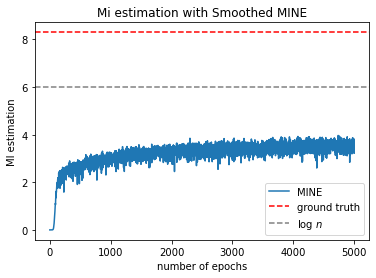

In [13]:
plt.plot(mi_list, label='MINE')

plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of epochs')
plt.ylabel('MI estimation')
plt.title('Mi estimation with Smoothed MINE')
plt.legend()
plt.savefig(f'results/MINE_dim{opt.d}_batchsize{opt.batch_size}.pdf')